## Trial

In [1]:
import json
import pandas as pd
from sklearn.metrics import silhouette_score,calinski_harabasz_score,pairwise_distances
from Kernels.src.Analysis.Clustering import *
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score
from sklearn.metrics import adjusted_rand_score
import itertools
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.mosaicplot import mosaic
import lifelines
import statsmodels.api as sm
import itertools
from scipy import stats
import plotly.graph_objects as go
from matplotlib.offsetbox import AnchoredText
import matplotlib.font_manager as fm


In [4]:
import seaborn as sns

In [2]:
fontPath = "/CTGlab/home/danilo/.fonts/Inter-VariableFont_wght.ttf" 

### Time scaling

In [3]:
data_time = {
    'Time_old(h)': [0.27,1, 1.51],
    'Time_new(h)': [0.3,7,13],
    'N': [500,1000, 1200]
}

df_time=pd.DataFrame(data_time)


/tmp/ipykernel_662114/3784274851.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_time,y='Time_old(h)',x='N',palette="tab10", linewidth=2.5)
/tmp/ipykernel_662114/3784274851.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_time,y='Time_new(h)',x='N',palette="tab10", linewidth=2.5)


<Axes: xlabel='N', ylabel='Time_old(h)'>

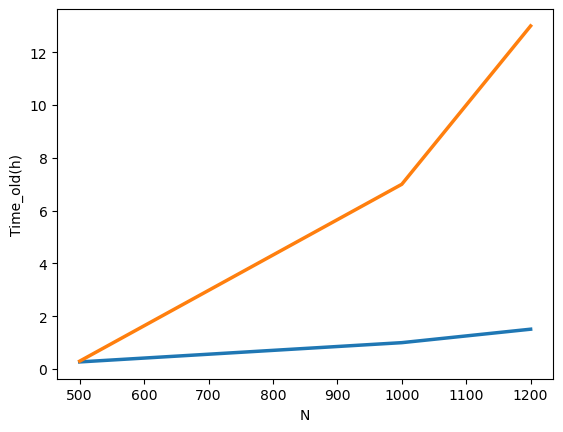

In [8]:
sns.lineplot(data=df_time,y='Time_old(h)',x='N',palette="tab10", linewidth=2.5)
sns.lineplot(data=df_time,y='Time_new(h)',x='N',palette="tab10", linewidth=2.5)

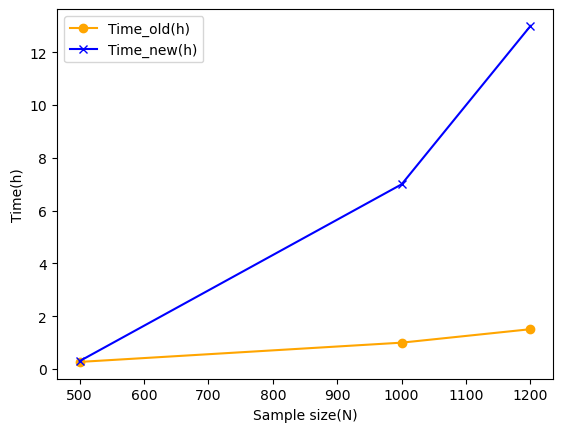

In [11]:
plt.plot([500,1000,1200],[0.27,1,1.51],marker='o',color='orange',label='qiskit_qml 0.4.0')
plt.plot([500,1000,1200],[0.3,7,13],marker='x',color='blue',label='qiskit_qml 0.7.1')
plt.xlabel('Sample size(N)')
plt.ylabel('Time(h)')
plt.legend()

# COSE

In [3]:
data_input = pd.read_csv("Input_data/UMAP_METABRIC_4cmp_IC10_full.csv", sep = ",",index_col=0)
data_input=data_input.sample(n=100,axis=0,random_state=42)
df_new_clust=pd.DataFrame()
df_new_clust.index=data_input.index

In [4]:
#get classical kernel
#SELECT FT
n_qubits=4
features=[]
for i in range(1,int(n_qubits)+1):
    name_cna='Component_'+str(i)
    features.append(name_cna)
labels = 'IntClustMemb'
print(features)

########SAMPLING###################################
y_train=data_input[labels].to_numpy()
X_train=data_input[features]

['Component_1', 'Component_2', 'Component_3', 'Component_4']


In [5]:
#CHI from sklearn
chi_sk=calinski_harabasz_score(X_train,y_train)
#CHI home made
dist_matrix=pairwise_distances(X_train,X_train,metric='euclidean')
chi_hm=Calinski_Harabasz_Index(distance_matrix=dist_matrix,labels=y_train)
print(chi_sk,chi_hm)

TypeError: Calinski_Harabasz_Index() missing 1 required positional argument: 'X'

In [ ]:
dist_matrix.shape

(1000, 1000)

In [7]:
qk=pd.read_pickle("Kernels_Results/Supervised_1000/10_classes/Z_full/qk_tot_tr_0.125.pickle")
qk.shape

(220, 220)

## IGP

In [43]:
#Load qmatrix
qk=pd.read_pickle('Kernels_Results/Unsupervised_1000_umap/ZZ_full/qk_tot_2.pickle')
#Perform clustering
clustering=SpectralClustering(n_clusters=10,affinity='precomputed',random_state=42)
labels=clustering.fit_predict(qk)
#From affinaty to distance
q_k_dist=1-Scale(qk,(0,1))

In [44]:


# Assuming you have an affinity matrix `affinity_matrix`
# and labels of each sample in `labels`

# Find nearest neighbors
n_neighbors = 1  # You can adjust this as needed
neighbors = NearestNeighbors(n_neighbors=n_neighbors, metric='precomputed')
neighbors.fit(q_k_dist)
distances, indices = neighbors.kneighbors()

# Initialize a dictionary to store counts for each class
class_counts = {label: 0 for label in set(labels)}

# Count occurrences of nearest neighbors in the same class
for i, label in enumerate(labels):
    nearest_neighbor_index = indices[i, 0]  # Index of the nearest neighbor
    nearest_neighbor_label = labels[nearest_neighbor_index]
    
    if label == nearest_neighbor_label:
        class_counts[label] += 1

# Print or use the class counts as needed
for label, count in class_counts.items():
    print(f'Class {label}: {count} samples with nearest neighbor in the same class')


Class 0: 62 samples with nearest neighbor in the same class
Class 1: 68 samples with nearest neighbor in the same class
Class 2: 56 samples with nearest neighbor in the same class
Class 3: 104 samples with nearest neighbor in the same class
Class 4: 91 samples with nearest neighbor in the same class
Class 5: 59 samples with nearest neighbor in the same class
Class 6: 87 samples with nearest neighbor in the same class
Class 7: 90 samples with nearest neighbor in the same class
Class 8: 76 samples with nearest neighbor in the same class
Class 9: 67 samples with nearest neighbor in the same class


In [45]:
#Evaluate igp
IGPs={}
for class_ in set(labels):
    class_size=labels.tolist().count(class_)
    
    IGPs[class_]=class_counts[class_]/class_size
    print('Class {} has IGP : {} '.format(class_,IGPs[class_]))


Class 0 has IGP : 0.8266666666666667 
Class 1 has IGP : 0.723404255319149 
Class 2 has IGP : 0.7887323943661971 
Class 3 has IGP : 0.7878787878787878 
Class 4 has IGP : 0.7913043478260869 
Class 5 has IGP : 0.7023809523809523 
Class 6 has IGP : 0.8365384615384616 
Class 7 has IGP : 0.7692307692307693 
Class 8 has IGP : 0.76 
Class 9 has IGP : 0.6203703703703703 


In [46]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Assuming you have an affinity matrix `affinity_matrix`
# and labels of each sample in `labels`

# Find nearest neighbors
n_neighbors = 1  # You can adjust this as needed
neighbors = NearestNeighbors(n_neighbors=n_neighbors, metric='precomputed')
neighbors.fit(q_k_dist)
distances, indices = neighbors.kneighbors()

# Count occurrences of nearest neighbors in the same class
class_counts = {label: 0 for label in np.unique(labels)}
total_samples_per_class = {label: 0 for label in np.unique(labels)}

for i, label in enumerate(labels):
    nearest_neighbor_index = indices[i, 0]  # Index of the nearest neighbor
    nearest_neighbor_label = labels[nearest_neighbor_index]
    
    if label == nearest_neighbor_label:
        class_counts[label] += 1
    
    total_samples_per_class[label] += 1

# Normalize the counts by the total number of samples in each class
normalized_counts = {label: count / total_samples_per_class[label] for label, count in class_counts.items()}

# Print or use the normalized counts as needed
for label, count in normalized_counts.items():
    print(f'Class {label}: {count:.2f} IGP')


Class 0: 0.83 IGP
Class 1: 0.72 IGP
Class 2: 0.79 IGP
Class 3: 0.79 IGP
Class 4: 0.79 IGP
Class 5: 0.70 IGP
Class 6: 0.84 IGP
Class 7: 0.77 IGP
Class 8: 0.76 IGP
Class 9: 0.62 IGP


## Silhouette analysis

For n_clusters = 10 The average silhouette_score is : 0.3418866542418854


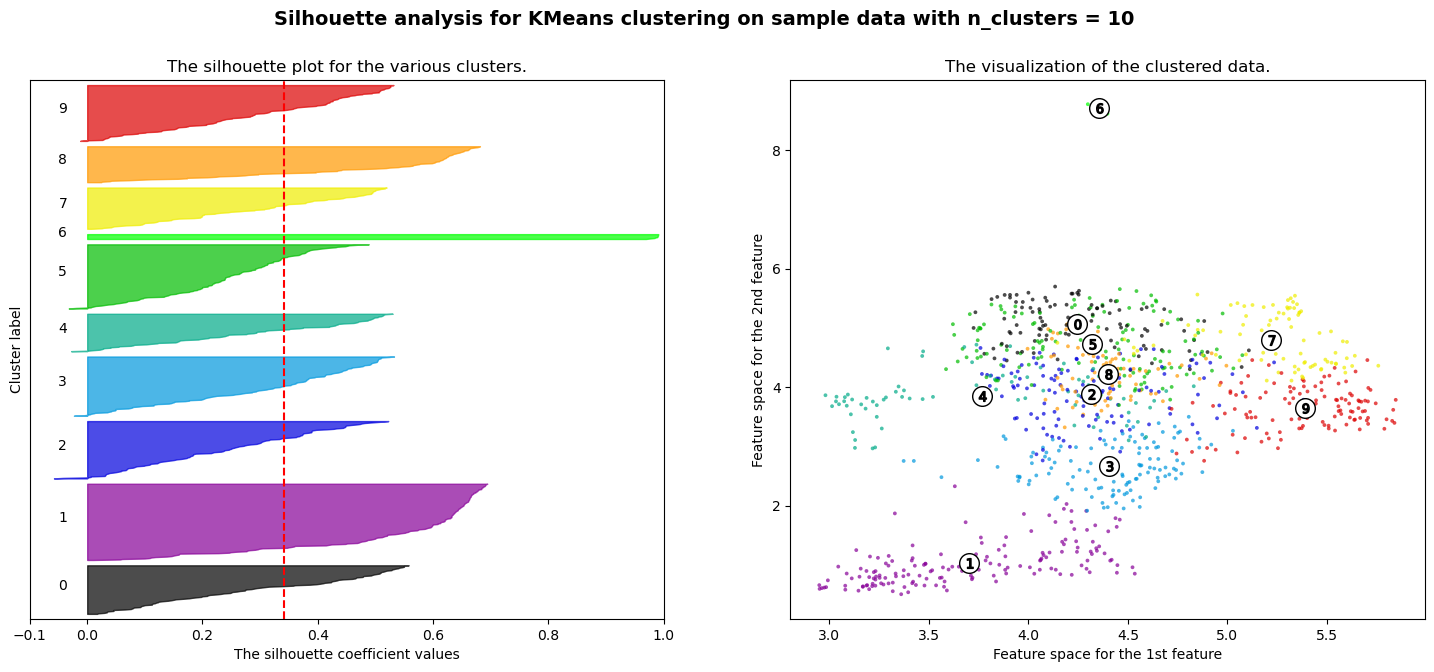

In [12]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X=X_train.to_numpy()
range_n_clusters = [10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [21]:
def Silhouette_analysis(X,cluster_labels,n_clusters):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
   
    silhouette_avg = silhouette_score(X, cluster_labels)
     # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower=10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.\n (Silhouette score {}) ".format(np.round(silhouette_avg,3)))
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis  for clustering on sample data with n_clusters = {}".format(n_clusters,),
        fontsize=14,
        fontweight="bold",
    )
plt.savefig('Silhouette_analysis_{}.png'.format(n_clusters))

    


    
    

    


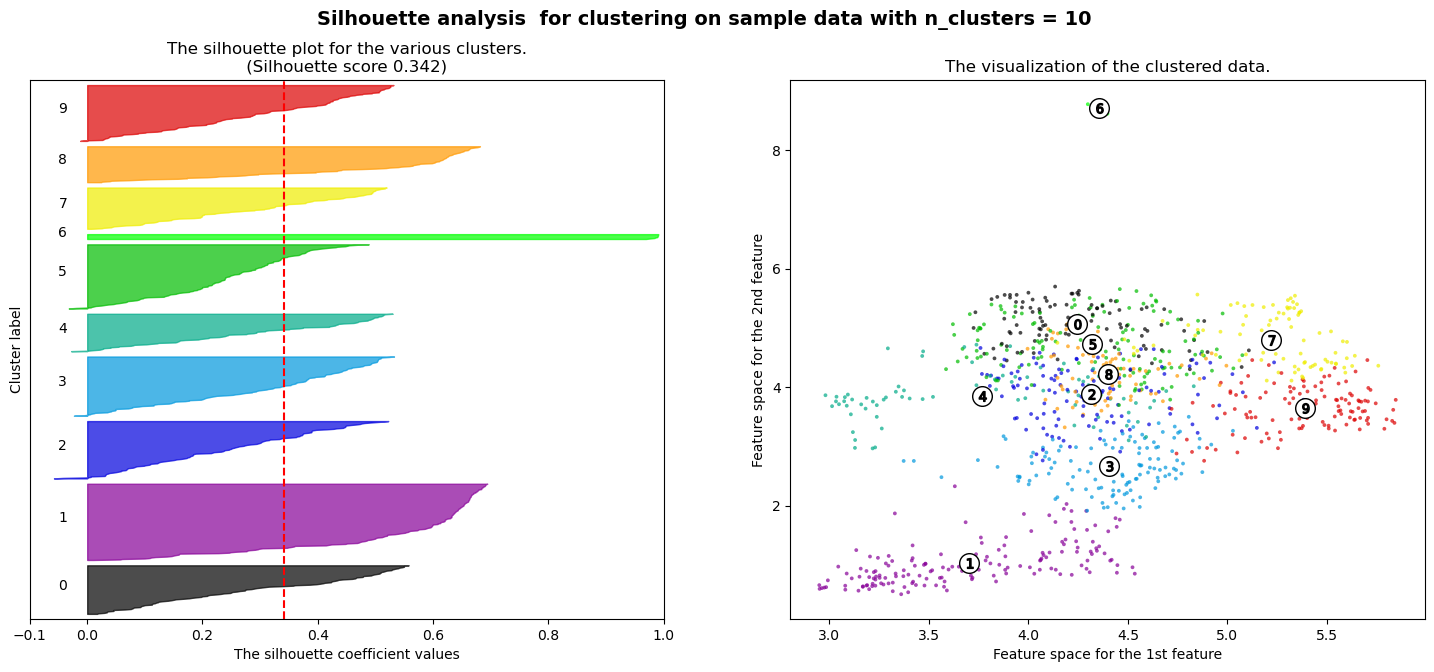

In [22]:
Silhouette_analysis(X,cluster_labels=cluster_labels,n_clusters=10)

# Hardware comparison

In [5]:
outdir='/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_umap_100_hardware/Prove_CU/'
df_real=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_umap_100_hardware/Prove_CU/clustering_100_opt_k_reviewed.csv')
df_sim=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_100_umap/clustering_100_opt_k_reviewed.csv')

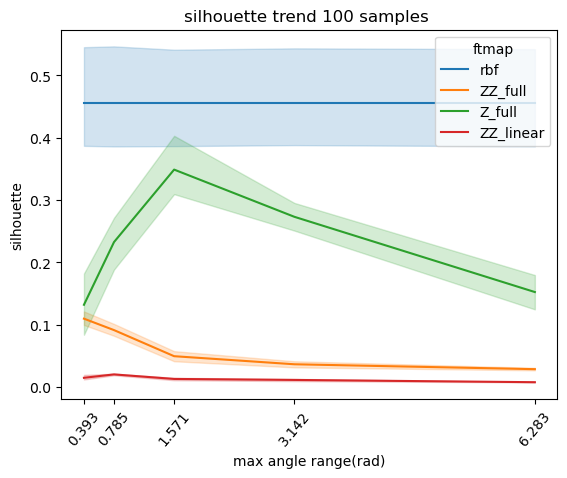

In [6]:
df_real['Max angle']=df_real['Bandwidth']*np.pi
g=sns.lineplot(data=df_real,x='Max angle',y='silhouette',hue='ftmap')
plt.title('{} trend {} samples '.format('silhouette',df_real.N_samples[0]))
plt.xlabel('max angle range(rad)')
#plt.ylim(0,0.4)
plt.xticks(df_real['Max angle'].unique(),rotation=50)
sns.move_legend(g, "upper right")


In [7]:

#Tag simulated and real data
df_real['Type']=['Real']*len(df_real)
df_sim['Type']=['Simulated']*len(df_sim)


In [8]:
df= pd.concat([df_sim, df_real], axis=0, ignore_index=True)

In [9]:
df.replace('Z_full','Z',inplace=True)


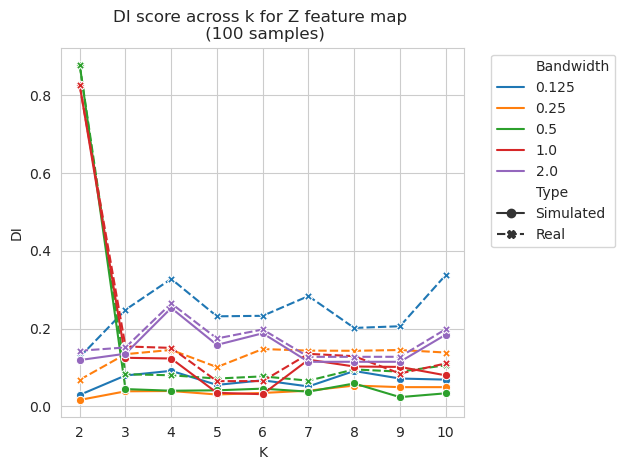

In [10]:

ft_map_to_plot='Z'
score_to_plot='DI'
sns.set_style("whitegrid")

sns.lineplot(data=df[df['ftmap'].isin([ft_map_to_plot])],
             x='K',y=score_to_plot,style='Type',hue='Bandwidth',markers=True,palette='tab10')


# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('{} score across k for {} feature map \n ({} samples)'.format(score_to_plot,ft_map_to_plot,df.N_samples[0]))
plt.tight_layout()
# Show the plot
plt.savefig(outdir+'{}_ftmap_coherence_{}_score.png'.format(ft_map_to_plot,score_to_plot))


### Second-take ZZ-linear

Given that the ZZ-linear results are drammatically different from the simulation we repeted the run and here are the results, finally:

In [13]:
df_st=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_umap_100_hardware/Prove_CU/Second-takeclustering_100_opt_k_reviewed.csv')

In [14]:
df_st['Max angle']=df_st['Bandwidth']*np.pi
df_st['Type']=['Real']*len(df_st)
df_2= pd.concat([df_st, df_sim], axis=0, ignore_index=True)


In [16]:
df_st.head()

,Unnamed: 0,ftmap,K,Bandwidth,s,geom_distance,concentration,silhouette,Score_cluster,CHI,DI,v_intra,v_inter,N_samples,Max angle,Type
0,0,rbf,2,0.125,17881.043575,1.751525,0.040536,0.769213,0.761888,44.248236,0.948850,0.019627,0.007880,100,0.392699,Real
1,1,rbf,3,0.125,17881.043575,1.751525,0.040536,0.578659,0.669947,75.249441,0.026336,0.006730,0.050097,100,0.392699,Real
2,2,rbf,4,0.125,17881.043575,1.751525,0.040536,0.381487,0.639101,66.995311,0.022874,0.005174,0.046837,100,0.392699,Real
3,3,rbf,5,0.125,17881.043575,1.751525,0.040536,0.339353,0.644123,56.611376,0.015088,0.004944,0.044443,100,0.392699,Real
4,4,rbf,6,0.125,17881.043575,1.751525,0.040536,0.392213,0.700089,59.503937,0.016159,0.003948,0.042539,100,0.392699,Real


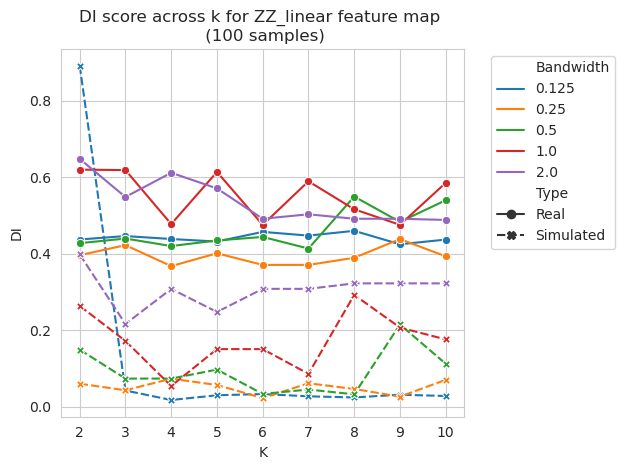

In [22]:
ft_map_to_plot='ZZ_linear'
score_to_plot='DI'
sns.set_style("whitegrid")

sns.lineplot(data=df_2[df_2['ftmap'].isin([ft_map_to_plot])],
             x='K',y=score_to_plot,style='Type',hue='Bandwidth',markers=True,palette='tab10')


# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('{} score across k for {} feature map \n ({} samples)'.format(score_to_plot,ft_map_to_plot,df.N_samples[0]))
plt.tight_layout()
# Show the plot
plt.savefig(outdir+'{}_ftmap_coherence_{}_score_st.png'.format(ft_map_to_plot,score_to_plot))


## Clustering coherence

In [23]:
df_clust_real=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_umap_100_hardware/Prove_CU/clustering_100_clusters.csv',index_col=0)
df_clust_sim=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_100_umap/clustering_100_clusters.csv',index_col=0)

Calculate NMI and Rand Index between the simulation results and its real counterpart

In [24]:
for col in df_clust_real.columns:
    print(col)

Cluster_rbf_2_0.125
Cluster_rbf_3_0.125
Cluster_rbf_4_0.125
Cluster_rbf_5_0.125
Cluster_rbf_6_0.125
Cluster_rbf_7_0.125
Cluster_rbf_8_0.125
Cluster_rbf_9_0.125
Cluster_rbf_10_0.125
Cluster_rbf_2_0.25
Cluster_rbf_3_0.25
Cluster_rbf_4_0.25
Cluster_rbf_5_0.25
Cluster_rbf_6_0.25
Cluster_rbf_7_0.25
Cluster_rbf_8_0.25
Cluster_rbf_9_0.25
Cluster_rbf_10_0.25
Cluster_rbf_2_0.5
Cluster_rbf_3_0.5
Cluster_rbf_4_0.5
Cluster_rbf_5_0.5
Cluster_rbf_6_0.5
Cluster_rbf_7_0.5
Cluster_rbf_8_0.5
Cluster_rbf_9_0.5
Cluster_rbf_10_0.5
Cluster_rbf_2_1
Cluster_rbf_3_1
Cluster_rbf_4_1
Cluster_rbf_5_1
Cluster_rbf_6_1
Cluster_rbf_7_1
Cluster_rbf_8_1
Cluster_rbf_9_1
Cluster_rbf_10_1
Cluster_rbf_2_2
Cluster_rbf_3_2
Cluster_rbf_4_2
Cluster_rbf_5_2
Cluster_rbf_6_2
Cluster_rbf_7_2
Cluster_rbf_8_2
Cluster_rbf_9_2
Cluster_rbf_10_2
Cluster_ZZ_full_2_0.125
Cluster_ZZ_full_3_0.125
Cluster_ZZ_full_4_0.125
Cluster_ZZ_full_5_0.125
Cluster_ZZ_full_6_0.125
Cluster_ZZ_full_7_0.125
Cluster_ZZ_full_8_0.125
Cluster_ZZ_full_9_0.125
Cl

In [25]:
#calculate nmi, ami and ari between real and simulated comon columns
#save the results in a dictionary

nmi_ari_dict_list=[]
for col in df_clust_real.columns:
    print(col)
    clust=col.split('_')
    print(clust)

    if clust[1]=='Z':
        ftmap=clust[1]

        
    elif clust[1]=='ZZ':
        ftmap=clust[1]+'_'+clust[2]
    else:
        ftmap='rbf'
    print(ftmap)
    ari=adjusted_rand_score(df_clust_real[col],df_clust_sim[col])
    nmi=normalized_mutual_info_score(df_clust_real[col],df_clust_sim[col])
    ami=adjusted_mutual_info_score(df_clust_real[col],df_clust_sim[col])
    print('ARI for {} is {}'.format(col,ari))
    print('NMI for {} is {}'.format(col,nmi))
    print('AMI for {} is {}'.format(col,ami))


    nmi_ari_dict_list.append({'ftmap':ftmap,
                              'K':clust[-2],
                              'Bandwidth':clust[-1],
                              'ARI':ari,
                              'NMI':nmi,
                              'AMI':ami})


Cluster_rbf_2_0.125
['Cluster', 'rbf', '2', '0.125']
rbf
ARI for Cluster_rbf_2_0.125 is 1.0
NMI for Cluster_rbf_2_0.125 is 1.0
AMI for Cluster_rbf_2_0.125 is 1.0
Cluster_rbf_3_0.125
['Cluster', 'rbf', '3', '0.125']
rbf
ARI for Cluster_rbf_3_0.125 is 1.0
NMI for Cluster_rbf_3_0.125 is 1.0
AMI for Cluster_rbf_3_0.125 is 1.0
Cluster_rbf_4_0.125
['Cluster', 'rbf', '4', '0.125']
rbf
ARI for Cluster_rbf_4_0.125 is 1.0
NMI for Cluster_rbf_4_0.125 is 1.0
AMI for Cluster_rbf_4_0.125 is 1.0
Cluster_rbf_5_0.125
['Cluster', 'rbf', '5', '0.125']
rbf
ARI for Cluster_rbf_5_0.125 is 1.0
NMI for Cluster_rbf_5_0.125 is 1.0
AMI for Cluster_rbf_5_0.125 is 1.0
Cluster_rbf_6_0.125
['Cluster', 'rbf', '6', '0.125']
rbf
ARI for Cluster_rbf_6_0.125 is 1.0
NMI for Cluster_rbf_6_0.125 is 1.0
AMI for Cluster_rbf_6_0.125 is 1.0
Cluster_rbf_7_0.125
['Cluster', 'rbf', '7', '0.125']
rbf
ARI for Cluster_rbf_7_0.125 is 1.0
NMI for Cluster_rbf_7_0.125 is 1.0
AMI for Cluster_rbf_7_0.125 is 1.0
Cluster_rbf_8_0.125
['Cluste

In [26]:
#List of dictionaries to dataframe
df_nmi_ari=pd.DataFrame(nmi_ari_dict_list)

In [27]:
df_nmi_ari

,ftmap,K,Bandwidth,ARI,NMI,AMI
0,rbf,2,0.125,1.000000,1.000000,1.000000
1,rbf,3,0.125,1.000000,1.000000,1.000000
2,rbf,4,0.125,1.000000,1.000000,1.000000
3,rbf,5,0.125,1.000000,1.000000,1.000000
4,rbf,6,0.125,1.000000,1.000000,1.000000
...,...,...,...,...,...,...
175,ZZ_linear,6,2,0.024634,0.185583,0.106522
176,ZZ_linear,7,2,0.026755,0.208716,0.104244
177,ZZ_linear,8,2,0.022788,0.209875,0.078298
178,ZZ_linear,9,2,0.024676,0.238601,0.078592


In [11]:
df_nmi_ari[(df_nmi_ari['ftmap'].isin(['ZZ_full'])) & (df_nmi_ari['Bandwidth'].isin(['0.125']))]

,ftmap,K,Bandwidth,ARI,NMI,AMI
45,ZZ_full,2,0.125,0.835309,0.759024,0.756782
46,ZZ_full,3,0.125,0.932936,0.893895,0.891034
47,ZZ_full,4,0.125,0.888407,0.869677,0.864046
48,ZZ_full,5,0.125,0.799165,0.851326,0.841434
49,ZZ_full,6,0.125,0.590405,0.702903,0.675085
50,ZZ_full,7,0.125,0.778867,0.824708,0.802740
51,ZZ_full,8,0.125,0.618056,0.727987,0.683221
52,ZZ_full,9,0.125,0.533156,0.762204,0.712765
53,ZZ_full,10,0.125,0.613496,0.788437,0.734651


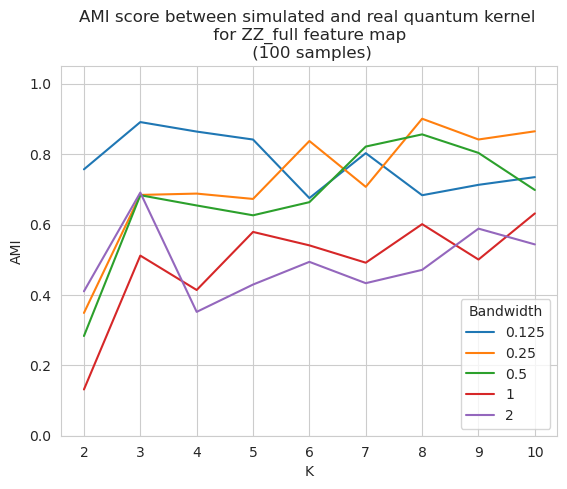

In [39]:
#Plot ARI and NMI
ft_map_to_plot='ZZ_full'
score_to_plot='AMI'
sns.set_style("whitegrid")
sns.lineplot(data=df_nmi_ari[df_nmi_ari['ftmap'].isin([ft_map_to_plot])],y=score_to_plot,x='K',hue='Bandwidth',markers=True,palette='tab10')
plt.ylim(0.00,1.05)
plt.title('{} score between simulated and real quantum kernel \n for {} feature map \n ({} samples)'.format(score_to_plot,ft_map_to_plot,df.N_samples[0]))
plt.savefig(outdir+'{}_ftmap_{}_score.png'.format(ft_map_to_plot,score_to_plot))

### Second take

In [29]:
df_clust_st=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_umap_100_hardware/Prove_CU/Second-takeclustering_100_clusters.csv',index_col=0)

In [32]:
#ARI and AMI for the second take
#calculate nmi, ami and ari between real and simulated comon columns
#save the results in a dictionary

nmi_ari_dict_list_2=[]
for col in df_clust_st.columns:
    
    clust=col.split('_')

    if clust[1]=='Z':
        ftmap=clust[1]

        
    elif clust[1]=='ZZ':
        ftmap=clust[1]+'_'+clust[2]
    else:
        ftmap='rbf'
    
    ari=adjusted_rand_score(df_clust_st[col],df_clust_sim[col])
    nmi=normalized_mutual_info_score(df_clust_st[col],df_clust_sim[col])
    ami=adjusted_mutual_info_score(df_clust_st[col],df_clust_sim[col])


    nmi_ari_dict_list_2.append({'ftmap':ftmap,
                              'K':clust[-2],
                              'Bandwidth':clust[-1],
                              'ARI':ari,
                              'NMI':nmi,
                              'AMI':ami})


In [33]:
#List of dictionaries to dataframe
df_nmi_ari_2=pd.DataFrame(nmi_ari_dict_list_2)

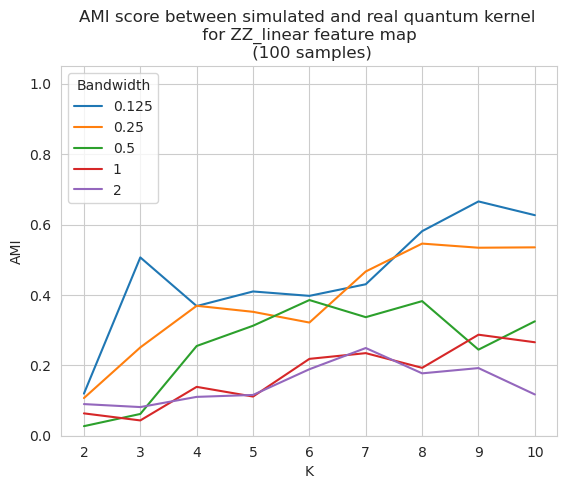

In [40]:
#Plot ARI and NMI
ft_map_to_plot='ZZ_linear'
score_to_plot='AMI'
sns.set_style("whitegrid")
sns.lineplot(data=df_nmi_ari_2[df_nmi_ari_2['ftmap'].isin([ft_map_to_plot])],y=score_to_plot,x='K',hue='Bandwidth',markers=True,palette='tab10')
plt.ylim(0.0,1.05)
plt.title('{} score between simulated and real quantum kernel \n for {} feature map \n ({} samples)'.format(score_to_plot,ft_map_to_plot,df.N_samples[0]))
plt.savefig(outdir+'{}_ftmap_{}_score_st.png'.format(ft_map_to_plot,score_to_plot))

# Check Survival

For 1000 samples case

In [6]:
data_input

,Component_1,Component_2,Component_3,Component_4,IntClustMemb
MB-4270,4.459003,1.762128,8.716180,3.800151,9
MB-6068,3.232354,0.750432,9.716409,3.052997,4
MB-0666,4.351296,3.491412,9.277145,2.818116,9
MB-7010,5.542212,4.578652,9.395142,3.620670,7
MB-7036,3.751446,0.916476,9.636867,2.495010,10
...,...,...,...,...,...
MB-3351,3.863398,4.373843,9.367185,2.028247,3
MB-0615,4.540109,3.731272,10.014156,2.037181,5
MB-3466,4.534412,3.938404,9.328135,2.299947,2
MB-0301,5.592884,3.783750,9.421013,2.585854,7


In [7]:
#Load original patient index from data and metabric data(metadata)
#Load clustering data
df_clust=pd.read_csv('/CTGlab/home/valeria/Quantum-Machine-Learning-for-Expression-Data/Results/Unsupervised_1000_umap/clustering_1000_clusters.csv',index_col=0)
data_input = pd.read_csv("Input_data/UMAP_METABRIC_4cmp_IC10_full.csv", sep = ",",index_col=0)
patient_index=data_input.sample(n=1000,axis=0,random_state=42).index
#set index to df_clust to patient index
df_clust.index=patient_index

#Load metadata
metabric = pd.read_csv('/CTGlab/data/brca_metabric/data_clinical_patient.txt', sep='\t', skiprows=[0,1,2,3])

prepare data also for survival

In [8]:
#Remove patients with missing OS_STATUS and merge with data
metabricSubset = metabric.loc[~metabric['OS_STATUS'].isna()]
quantumDf = pd.merge(metabricSubset, df_clust, how='left', right_on=[df_clust.index], left_on=['PATIENT_ID']).dropna(subset=df_clust.columns)
quantumDf['OS_STATUS_censored'] = quantumDf['VITAL_STATUS'].apply(lambda x: 1 if x == "Died of Disease" else 0) 
quantumDf['OS_STATUS'] = quantumDf['OS_STATUS'].apply(lambda x: int(x.split(':')[0]))

In [9]:
quantumDf

,PATIENT_ID,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,CHEMOTHERAPY,COHORT,ER_IHC,HER2_SNP6,HORMONE_THERAPY,INFERRED_MENOPAUSAL_STATE,...,Cluster_ZZ_linear_2_2,Cluster_ZZ_linear_3_2,Cluster_ZZ_linear_4_2,Cluster_ZZ_linear_5_2,Cluster_ZZ_linear_6_2,Cluster_ZZ_linear_7_2,Cluster_ZZ_linear_8_2,Cluster_ZZ_linear_9_2,Cluster_ZZ_linear_10_2,OS_STATUS_censored
0,MB-0000,10.0,6.044,NaN,NO,1.0,Positve,NEUTRAL,YES,Post,...,1.0,0.0,3.0,4.0,4.0,6.0,7.0,0.0,9.0,0
2,MB-0005,1.0,4.030,High,YES,1.0,Positve,NEUTRAL,YES,Pre,...,0.0,2.0,2.0,3.0,3.0,4.0,5.0,3.0,4.0,1
3,MB-0006,3.0,4.050,Moderate,YES,1.0,Positve,NEUTRAL,YES,Pre,...,1.0,0.0,1.0,1.0,4.0,0.0,2.0,0.0,6.0,0
6,MB-0014,1.0,4.020,Moderate,YES,1.0,Positve,LOSS,YES,Post,...,1.0,0.0,1.0,1.0,4.0,0.0,2.0,0.0,6.0,0
7,MB-0020,NaN,6.130,High,YES,1.0,Negative,NEUTRAL,NO,Post,...,1.0,2.0,0.0,2.0,1.0,1.0,4.0,1.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972,MB-7291,22.0,6.100,High,NO,4.0,Positve,GAIN,YES,Post,...,1.0,2.0,0.0,1.0,1.0,2.0,4.0,1.0,3.0,1
1973,MB-7292,1.0,4.030,High,NO,4.0,Positve,GAIN,YES,Post,...,1.0,0.0,0.0,1.0,4.0,0.0,2.0,0.0,6.0,1
1974,MB-7293,1.0,5.090,High,NO,4.0,Positve,NEUTRAL,YES,Post,...,1.0,0.0,1.0,1.0,4.0,0.0,2.0,1.0,6.0,0
1976,MB-7295,1.0,5.050,High,NO,4.0,Positve,NEUTRAL,YES,Pre,...,1.0,1.0,1.0,4.0,0.0,0.0,2.0,1.0,6.0,0


In [10]:
def plot_KM_curves(survDf: pd.DataFrame, durationVar: str, eventVar: str, indVar: str, ax=None, groups=None, **kwargs):
    """
    Plot KM curve with respect to an independent variable, including logrank test.

    Parameters:
    - survDf (pd.DataFrame): dataframe
    - durationVar (str): Column name with survival time
    - eventVar (str): Column name denoting the event. Must be encoded as boolean or int (0,1)
    - indVar (str): Column name with the independent variable. If it contains more than two different values, the groups 
        to be tested with the log-rank must be provided with the groups argument
    - ax (plt.Axes): matplotlib axes
    - groups (Iterable): Iterable containing values to be tested for logrank
    - **kwargs: arguments for the lifelines.KaplanMeierFitter function.

    Returns:

    plt.Axes
    """
    levels = np.sort(survDf[indVar].dropna().unique())
    if len(levels) == 2:
            pval = lifelines.statistics.logrank_test(
            durations_A=survDf[survDf[indVar] == levels[0]][durationVar],
            durations_B=survDf[survDf[indVar] == levels[1]][durationVar],
            events_observed_A=survDf[survDf[indVar] == levels[0]][eventVar],
            events_observed_B=survDf[survDf[indVar] == levels[1]][eventVar]
            ).p_value
    else:
        try:
            iter(groups)
            pval = lifelines.statistics.logrank_test(
                durations_A=survDf[survDf[indVar] == groups[0]][durationVar],
                durations_B=survDf[survDf[indVar] == groups[1]][durationVar],
                events_observed_A=survDf[survDf[indVar] == groups[0]][eventVar],
                events_observed_B=survDf[survDf[indVar] == groups[1]][eventVar]
                ).p_value
        except TypeError:
            print('Groups require an iterable containing two variables to compare between')
            return None
    kmPlots = [None for _ in levels]
    # calc the p-val
    at = AnchoredText('$p$: {}'.format(float(np.round(pval, 7))),prop=dict(fontproperties=fm.FontProperties(fname=fontPath, size=12)), frameon=True, loc='lower left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    # ax.set_title(f'KM curve for covariate "{var}"')
    ax.add_artist(at)
    ax.set_facecolor('none')
    ax.set_ylim(0, 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    for idx,level in enumerate(levels):
        kmPlots[idx] = lifelines.KaplanMeierFitter()
        events = (survDf[indVar] == level)
        kmPlots[idx].fit(
            durations=survDf[durationVar][events],
            event_observed=survDf[eventVar][events],
            label=level)
        kmPlots[idx].plot(ax=ax, **kwargs, lw=2.5, color=sns.color_palette('colorblind')[idx])
    lifelines.plotting.add_at_risk_counts(*kmPlots, ax=ax, fontproperties=fm.FontProperties(fname=fontPath, size=10))


    return ax

In [11]:
quantumDf['VITAL_STATUS'].value_counts()


VITAL_STATUS
Living                  435
Died of Disease         313
Died of Other Causes    251
Name: count, dtype: int64

In [12]:
quantumDf['OS_MONTHS'].describe()

count    1000.000000
mean      128.472167
std        75.786077
min         0.000000
25%        64.541667
50%       122.733333
75%       186.558333
max       355.200000
Name: OS_MONTHS, dtype: float64

In [13]:
for i in quantumDf.columns:
    print(i)

PATIENT_ID
LYMPH_NODES_EXAMINED_POSITIVE
NPI
CELLULARITY
CHEMOTHERAPY
COHORT
ER_IHC
HER2_SNP6
HORMONE_THERAPY
INFERRED_MENOPAUSAL_STATE
SEX
INTCLUST
AGE_AT_DIAGNOSIS
OS_MONTHS
OS_STATUS
CLAUDIN_SUBTYPE
THREEGENE
VITAL_STATUS
LATERALITY
RADIO_THERAPY
HISTOLOGICAL_SUBTYPE
BREAST_SURGERY
RFS_STATUS
RFS_MONTHS
Cluster_rbf_2_0.125
Cluster_rbf_3_0.125
Cluster_rbf_4_0.125
Cluster_rbf_5_0.125
Cluster_rbf_6_0.125
Cluster_rbf_7_0.125
Cluster_rbf_8_0.125
Cluster_rbf_9_0.125
Cluster_rbf_10_0.125
Cluster_rbf_2_0.25
Cluster_rbf_3_0.25
Cluster_rbf_4_0.25
Cluster_rbf_5_0.25
Cluster_rbf_6_0.25
Cluster_rbf_7_0.25
Cluster_rbf_8_0.25
Cluster_rbf_9_0.25
Cluster_rbf_10_0.25
Cluster_rbf_2_0.5
Cluster_rbf_3_0.5
Cluster_rbf_4_0.5
Cluster_rbf_5_0.5
Cluster_rbf_6_0.5
Cluster_rbf_7_0.5
Cluster_rbf_8_0.5
Cluster_rbf_9_0.5
Cluster_rbf_10_0.5
Cluster_rbf_2_1
Cluster_rbf_3_1
Cluster_rbf_4_1
Cluster_rbf_5_1
Cluster_rbf_6_1
Cluster_rbf_7_1
Cluster_rbf_8_1
Cluster_rbf_9_1
Cluster_rbf_10_1
Cluster_rbf_2_2
Cluster_rbf_3_2

In [169]:
quantumDf['CLAUDIN_SUBTYPE'].value_counts()

CLAUDIN_SUBTYPE
LumA           35
LumB           22
Normal         13
Basal          13
claudin-low    10
Her2            7
Name: count, dtype: int64

Text(0, 0.5, 'Overall survival probability')

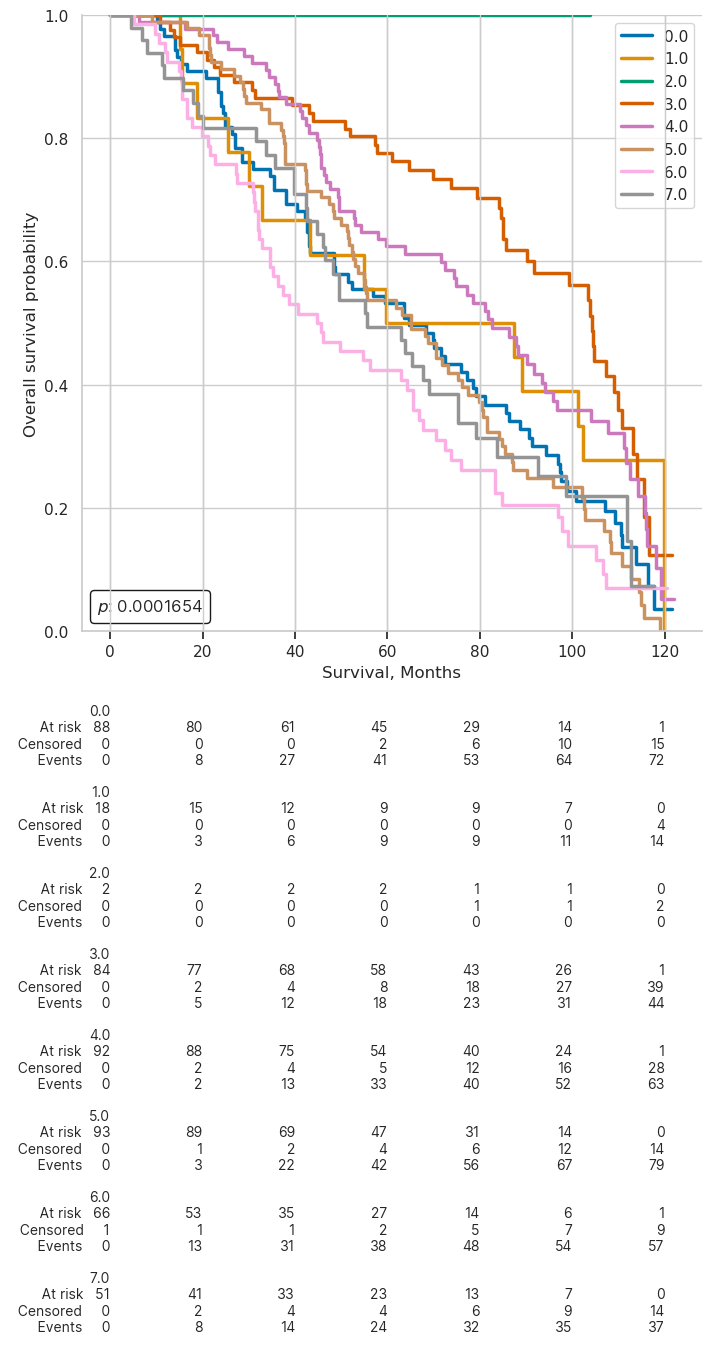

In [192]:
fig, ax = plt.subplots(figsize=(8,8))
plot_KM_curves(
    quantumDf.loc[quantumDf['OS_MONTHS'] < 122], durationVar='OS_MONTHS',eventVar='OS_STATUS', indVar='Cluster_ZZ_full_8_0.25', groups=[6,3], ax=ax, ci_show=False)
ax.set_xlabel('Survival, Months')
ax.set_ylabel('Overall survival probability')
#ax.legend( loc="best")
#ax.set_title('ZZ_linear_039 clustering \n 8 clusters')
#fig.tight_layout()

## Sankey

In [46]:
cluster_col=[]
for i in quantumDf.columns:
    if 'Cluster' in i:
        cluster_col.append(i)

In [51]:
quantumDf_s=quantumDf.copy()
for column in quantumDf_s.loc[:, ['INTCLUST','CLAUDIN_SUBTYPE']+cluster_col].columns:
    quantumDf_s[column] = quantumDf_s[column].apply(lambda x: f"{column}_{x}")

In [52]:
quantumDf_s.loc[:, ['INTCLUST','Cluster_ZZ_linear_7_0.125','Cluster_ZZ_full_7_0.125']].head()

,INTCLUST,Cluster_ZZ_linear_7_0.125,Cluster_ZZ_full_7_0.125
0,INTCLUST_4ER+,Cluster_ZZ_linear_7_0.125_4.0,Cluster_ZZ_full_7_0.125_4.0
2,INTCLUST_3,Cluster_ZZ_linear_7_0.125_0.0,Cluster_ZZ_full_7_0.125_6.0
3,INTCLUST_9,Cluster_ZZ_linear_7_0.125_1.0,Cluster_ZZ_full_7_0.125_2.0
6,INTCLUST_3,Cluster_ZZ_linear_7_0.125_1.0,Cluster_ZZ_full_7_0.125_2.0
7,INTCLUST_4ER-,Cluster_ZZ_linear_7_0.125_4.0,Cluster_ZZ_full_7_0.125_4.0


In [63]:
def plotSankey(df: pd.DataFrame, cols: list, names=None,linkVar=None, valueToHighlight=None):
    """
    Plot a Sankey diagram based on the given dataframe and columns.

    Parameters:
    - df (pd.DataFrame): The dataframe containing the data.
    - cols (list): A list of column names to use for plotting.
    - linkVar (str): The name of the column to use as a link variable (optional).
    - valueToHighlight: The value in the link variable to highlight (optional).

    Returns:
    - fig: The generated plotly figure object.
    """
    colsToPlot = []
    for col in cols:
       colsToPlot.append(list(set(x for x in df[col])))

    mask = {}
    toenumerate = []
    for i in range(len(colsToPlot)):
       toenumerate = toenumerate + colsToPlot[i]
    for k,v in enumerate(toenumerate):
        mask[v] = k

    combinations = []
    for i in range(0, len(colsToPlot)-1):
       combinations = combinations + list(itertools.product(colsToPlot[i], colsToPlot[i+1]))
       

    sources = []
    targets = []
    values = []
    colors = []
    if linkVar != None:
      linkVarValues = df[linkVar].unique()
    for combination in combinations:
        source = mask[combination[0]]
        target = mask[combination[1]]
        column1 = '_'.join(combination[0].split('_')[:-1])
        column2 = '_'.join(combination[1].split('_')[:-1])
        
        if linkVar != None:
          for idx,val in enumerate(linkVarValues):
              flow = df.loc[(df[column1] == combination[0])&(df[column2] == combination[1])&(df[linkVar] == val)].shape[0]
              color = "lightgrey" if val != valueToHighlight else "orange"
              colors.append(color)
              sources.append(source) 
              targets.append(target)
              values.append(flow)
        else:
          flow = df.loc[(df[column1] == combination[0])&(df[column2] == combination[1])].shape[0]
          colors.append('lightgrey')
          sources.append(source) 
          targets.append(target)
          values.append(flow)
    
         
    fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = [f"{x.split('_')[-1]}" for x in toenumerate ]
    ),
    link = dict(
      source = sources, 
      target = targets,
      value = values,
      color = colors,
      label=[f"{x.split('_')[-1]}" for x in toenumerate ]
  ))])
    if names == None:
       names=cols
    for x_coordinate, column_name in enumerate(names):
        fig.add_annotation(
                x=x_coordinate,
                y=1.05,
                xref="x",
                yref="paper",
                text=column_name,
                showarrow=False,
                font=dict(
                    size=16,
                    color="black"
                    ),
                align="center",
                )
    fig.update_layout(
        title='Sample Assignments in Clustering Methods' if valueToHighlight==None else f"Sample Assignments in Clustering Methods\nHighlighted {valueToHighlight}",
        plot_bgcolor='white',
        paper_bgcolor='white',
        font_size=14,
        hovermode='x',
        autosize=False,
        width=1000, height=600,
        xaxis={
        'showgrid': False, # thin lines in the background
        'zeroline': False, # thick line at x=0
        'visible': False,  # numbers below
        },
        yaxis={
        'showgrid': False, # thin lines in the background
        'zeroline': False, # thick line at x=0
        'visible': False,  # numbers below
        }

    ) 
    fig.show()
    return fig

In [29]:
quantumDf_s.CELLULARITY.value_counts()

CELLULARITY
High        494
Moderate    355
Low         115
Name: count, dtype: int64

In [66]:
quantumDf_s.columns[:25]

Index(['PATIENT_ID', 'LYMPH_NODES_EXAMINED_POSITIVE', 'NPI', 'CELLULARITY',
       'CHEMOTHERAPY', 'COHORT', 'ER_IHC', 'HER2_SNP6', 'HORMONE_THERAPY',
       'INFERRED_MENOPAUSAL_STATE', 'SEX', 'INTCLUST', 'AGE_AT_DIAGNOSIS',
       'OS_MONTHS', 'OS_STATUS', 'CLAUDIN_SUBTYPE', 'THREEGENE',
       'VITAL_STATUS', 'LATERALITY', 'RADIO_THERAPY', 'HISTOLOGICAL_SUBTYPE',
       'BREAST_SURGERY', 'RFS_STATUS', 'RFS_MONTHS', 'Cluster_rbf_2_0.125'],
      dtype='object')

To plot


In [65]:
fig = plotSankey(quantumDf_s, cols=['INTCLUST','CLAUDIN_SUBTYPE','Cluster_ZZ_linear_10_0.25'],names=['INTCLUST','CLAUDIN_SUBTYPE','ZZ_linear(pi/4)'], valueToHighlight=['High'], linkVar='CELLULARITY')

# Check Clustering correlation with other variables


In [195]:
data_input

,Component_1,Component_2,Component_3,Component_4,IntClustMemb
MB-4666,5.497749,4.056644,9.238402,3.813853,7
MB-2851,3.134798,3.639698,10.175092,2.422124,4
MB-5366,4.140319,3.347784,8.551789,3.669222,5
MB-5341,5.439688,4.379867,9.285794,3.870328,2
MB-0358,5.223124,3.096975,9.557095,2.317304,9
...,...,...,...,...,...
MB-2849,3.129499,2.973610,10.085953,2.397814,9
MB-0022,4.345609,8.725343,6.175104,-0.403735,3
MB-4721,4.022290,4.786006,8.769722,4.222514,8
MB-5625,3.244882,1.117559,9.360249,3.188984,9


In [198]:
quantumDf.set_index('PATIENT_ID',inplace=True)

In [200]:
#Merge data_input with df_clust on index
df_new_clust=pd.merge(data_input.sample(n=1000,axis=0,random_state=42),quantumDf,how='left',left_index=True,right_index=True)
df_new_clust


,Component_1,Component_2,Component_3,Component_4,IntClustMemb,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,CHEMOTHERAPY,COHORT,...,Cluster_ZZ_linear_2_2,Cluster_ZZ_linear_3_2,Cluster_ZZ_linear_4_2,Cluster_ZZ_linear_5_2,Cluster_ZZ_linear_6_2,Cluster_ZZ_linear_7_2,Cluster_ZZ_linear_8_2,Cluster_ZZ_linear_9_2,Cluster_ZZ_linear_10_2,OS_STATUS_censored
MB-4270,4.459003,1.762128,8.716180,3.800151,9,4.0,5.036,NaN,YES,3.0,...,0.0,1.0,3.0,4.0,0.0,6.0,7.0,8.0,2.0,1
MB-6068,3.232354,0.750432,9.716409,3.052997,4,0.0,3.000,Moderate,NO,5.0,...,0.0,1.0,2.0,3.0,5.0,3.0,3.0,5.0,4.0,0
MB-0666,4.351296,3.491412,9.277145,2.818116,9,9.0,6.050,High,YES,1.0,...,1.0,0.0,1.0,1.0,4.0,2.0,0.0,6.0,5.0,1
MB-7010,5.542212,4.578652,9.395142,3.620670,7,0.0,2.046,Moderate,NO,4.0,...,0.0,1.0,1.0,1.0,5.0,3.0,3.0,5.0,1.0,0
MB-7036,3.751446,0.916476,9.636867,2.495010,10,2.0,5.036,High,YES,4.0,...,1.0,0.0,0.0,1.0,4.0,0.0,2.0,0.0,6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-3005,3.471740,4.602711,9.672564,2.170086,8,0.0,3.046,Moderate,NO,2.0,...,0.0,2.0,2.0,2.0,3.0,4.0,6.0,7.0,0.0,0
MB-6024,3.996194,4.647072,8.249059,4.461824,8,2.0,4.040,Moderate,NO,5.0,...,0.0,1.0,1.0,0.0,2.0,5.0,1.0,2.0,7.0,1
MB-0045,4.296920,1.071461,9.469940,2.832558,4,3.0,5.038,High,YES,1.0,...,1.0,1.0,3.0,0.0,2.0,5.0,1.0,2.0,7.0,0
MB-3430,3.837388,4.110645,8.960909,2.663787,3,1.0,5.050,High,NO,2.0,...,0.0,2.0,2.0,3.0,1.0,1.0,5.0,3.0,4.0,0


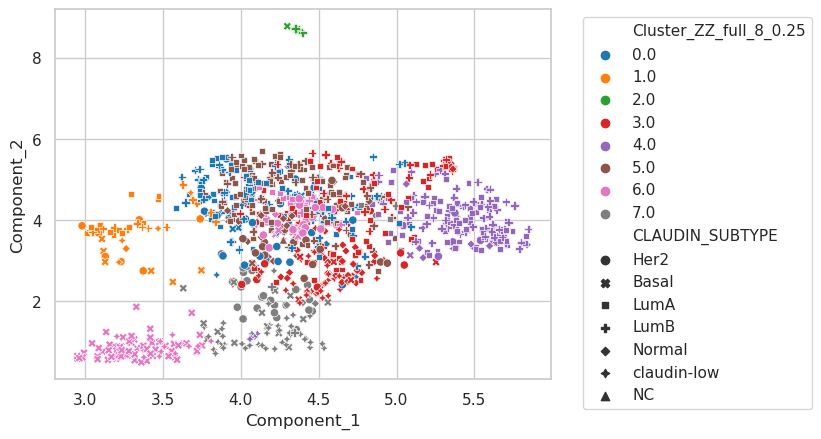

In [226]:
sns.scatterplot(data=df_new_clust,
                x='Component_1',
                y='Component_2',
                hue='Cluster_ZZ_full_8_0.25',
                style='CLAUDIN_SUBTYPE',
                palette='tab10')
# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

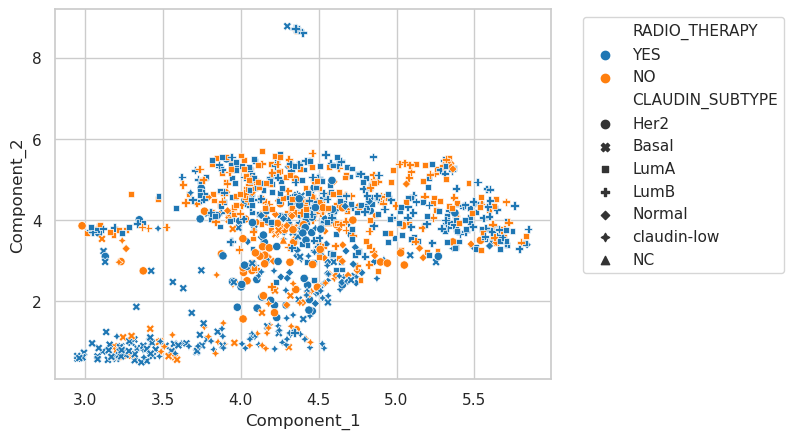

In [223]:
sns.scatterplot(data=df_new_clust,
                x='Component_1',
                y='Component_2',
                hue='RADIO_THERAPY',
                style='CLAUDIN_SUBTYPE',
                palette='tab10')
# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [207]:
df_new_clust['HORMONE_THERAPY'].value_counts()

HORMONE_THERAPY
YES    606
NO     394
Name: count, dtype: int64

In [214]:
quantumDf.columns[:20]

Index(['LYMPH_NODES_EXAMINED_POSITIVE', 'NPI', 'CELLULARITY', 'CHEMOTHERAPY',
       'COHORT', 'ER_IHC', 'HER2_SNP6', 'HORMONE_THERAPY',
       'INFERRED_MENOPAUSAL_STATE', 'SEX', 'INTCLUST', 'AGE_AT_DIAGNOSIS',
       'OS_MONTHS', 'OS_STATUS', 'CLAUDIN_SUBTYPE', 'THREEGENE',
       'VITAL_STATUS', 'LATERALITY', 'RADIO_THERAPY', 'HISTOLOGICAL_SUBTYPE'],
      dtype='object')

In [219]:
adjusted_mutual_info_score(df_new_clust['Cluster_ZZ_linear_8_0.25'],df_new_clust['SEX'])

0.0